# Random Forest Final Model - Gosan, South Korea

In [1]:
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_score, recall_score, f1_score
from joblib import dump
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

import sys
sys.path.append('../../')
import config

data_path = Path.home()/'OneDrive'/'Kirstin'/'Uni'/'Year4'/'MSciProject'/'data_files'/'saved_files'

In [2]:
site = config.site
site_name = config.site_dict[site]
assert site == 'GSN', 'This script is only for Gosan, South Korea. The site can be changed in the config file.'

compound = config.compound

print(f"Creating a random forest model for \033[1m{site_name}\033[0;0m.")

Creating a random forest model for Gosan, South Korea.


### Loading & Initialising Data

In [3]:
data = pd.read_csv(data_path/f'for_model_pca_{compound}_{site}.csv', parse_dates=['time'])
data.sample(5)

,time,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,...,PC12,PC13,PC14,PC15,PC16,PC17,PC18,PC19,PC20,flag
840,2008-07-06 17:00:00,10.114552,0.394195,-4.787538,0.727858,-1.314792,3.803592,0.656534,-1.797664,-0.585688,...,-1.297102,0.287016,0.055880,-0.272476,0.406260,0.335792,0.728346,1.812345,-0.163540,1.0
4530,2011-05-09 19:00:00,8.830898,6.376328,-0.459210,1.684401,-1.998382,4.154214,-1.574887,-0.655807,1.873395,...,0.648149,0.068042,2.072206,-1.847454,0.414482,0.668083,0.312856,1.292953,-1.573950,1.0
597,2008-03-04 21:00:00,-5.836566,-4.989330,-1.808652,-6.001572,-1.649599,-1.598932,1.279306,-0.957734,0.203406,...,-0.457681,0.601350,-0.082789,-0.335964,0.622046,1.233469,0.952288,0.933585,-0.741522,1.0
10164,2017-03-02 21:00:00,-3.096748,-3.080017,-5.281618,-3.007398,-0.975531,-1.479957,-0.556005,0.726406,0.837504,...,0.167424,-1.379095,0.167370,-0.206513,1.733314,2.881767,0.337823,1.075826,-0.086280,1.0
5226,2012-02-03 07:00:00,-5.268809,2.704941,-4.850681,-0.313818,-0.235600,-2.696297,1.094142,2.968283,0.810347,...,0.977549,0.152713,-0.059568,-1.066044,0.254287,-0.533067,-1.740204,0.964187,0.314754,1.0


In [4]:
train_data = data[(data['time'].dt.year >= 2011) & (data['time'].dt.year <= 2013)]
val_data = data[(data['time'].dt.year >= 2014) & (data['time'].dt.year <= 2014)]
test_data = data[(data['time'].dt.year >= 2015) & (data['time'].dt.year <= 2017)]


print(f"Train range: {train_data['time'].min()} -> {train_data['time'].max()}. Length: {len(train_data)}")
print(f"Val range: {val_data['time'].min()} -> {val_data['time'].max()}. Length: {len(val_data)}")
print(f"Test range: {test_data['time'].min()} -> {test_data['time'].max()}. Length: {len(test_data)}")


# Drop the "time" column as it won't be used in the model
train_data = train_data.drop(columns=['time'])
val_data = val_data.drop(columns=['time'])
test_data = test_data.drop(columns=['time'])

# Define the features (X) and the target (y)
X_train = train_data.drop(columns=['flag'])
y_train = train_data['flag']
X_val = val_data.drop(columns=['flag'])
y_val = val_data['flag']
X_test = test_data.drop(columns=['flag'])
y_test = test_data['flag']

# Balanced Data - removing NaN values and associated data
y_train = y_train.dropna()
y_val = y_val.dropna()
y_test = y_test.dropna()

# aligning indices of features sets
X_train = X_train.loc[y_train.index]
X_val = X_val.loc[y_val.index]
X_test = X_test.loc[y_test.index]

Train range: 2011-01-01 11:00:00 -> 2013-12-30 09:00:00. Length: 3186
Val range: 2014-01-03 19:00:00 -> 2014-12-31 23:00:00. Length: 933
Test range: 2015-01-01 01:00:00 -> 2017-12-31 23:00:00. Length: 2824


### Model

In [5]:
# fitting models based on optimal hyperparameters

rf_model = RandomForestClassifier(random_state=42,
                                  n_estimators=200,
                                  max_depth=5,
                                  criterion='entropy',
                                  bootstrap=True,
                                  max_features=None,)

rf_model.fit(X_train, y_train)

class_probabilities_val = rf_model.predict_proba(X_val)
class_probabilites_train = rf_model.predict_proba(X_train)

confidence_threshold = config.confidence_threshold

y_pred_val = (class_probabilities_val[:, 1] >= confidence_threshold).astype(int)
y_pred_train = (class_probabilites_train[:, 1] >= confidence_threshold).astype(int)


precision_val = precision_score(y_val, y_pred_val)
precision_train = precision_score(y_train, y_pred_train)
recall_val = recall_score(y_val, y_pred_val)
recall_train = recall_score(y_train, y_pred_train)
f1_val = f1_score(y_val, y_pred_val)
f1_train = f1_score(y_train, y_pred_train)

print(f"Precision on Training Set = {precision_train:.3f}")
print(f"Precision on Validation Set = {precision_val:.3f}")
print(f"Recall on Training Set = {recall_train:.3f}")
print(f"Recall on Validation Set = {recall_val:.3f}")
print(f"F1 Score on Training Set = {f1_train:.3f}")
print(f"F1 Score on Validation Set = {f1_val:.3f}")

Precision on Training Set = 0.976
Precision on Validation Set = 0.923
Recall on Training Set = 0.814
Recall on Validation Set = 0.596
F1 Score on Training Set = 0.888
F1 Score on Validation Set = 0.724


In [6]:
# evaluating the model on the test set

class_probabilities_test = rf_model.predict_proba(X_test)

y_pred_test = (class_probabilities_test[:, 1] >= confidence_threshold).astype(int)

precision_test = precision_score(y_test, y_pred_test)
recall_test = recall_score(y_test, y_pred_test)
f1_test = f1_score(y_test, y_pred_test)

print(f"Precision on Test Set = {precision_test:.3f}")
print(f"Recall on Test Set = {recall_test:.3f}")
print(f"F1 Score on Test Set = {f1_test:.3f}")

Precision on Test Set = 0.921
Recall on Test Set = 0.722
F1 Score on Test Set = 0.809


In [7]:
# saving model
dump(rf_model, data_path/f'rf_model_GSN.joblib')

['C:\\Users\\kirst\\OneDrive\\Kirstin\\Uni\\Year4\\MSciProject\\data_files\\saved_files\\rf_model_GSN.joblib']

### Assessing Feature Importance

C:\Users\kirst\AppData\Local\Temp\ipykernel_15352\1972167015.py:22: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(feature_importances.index)


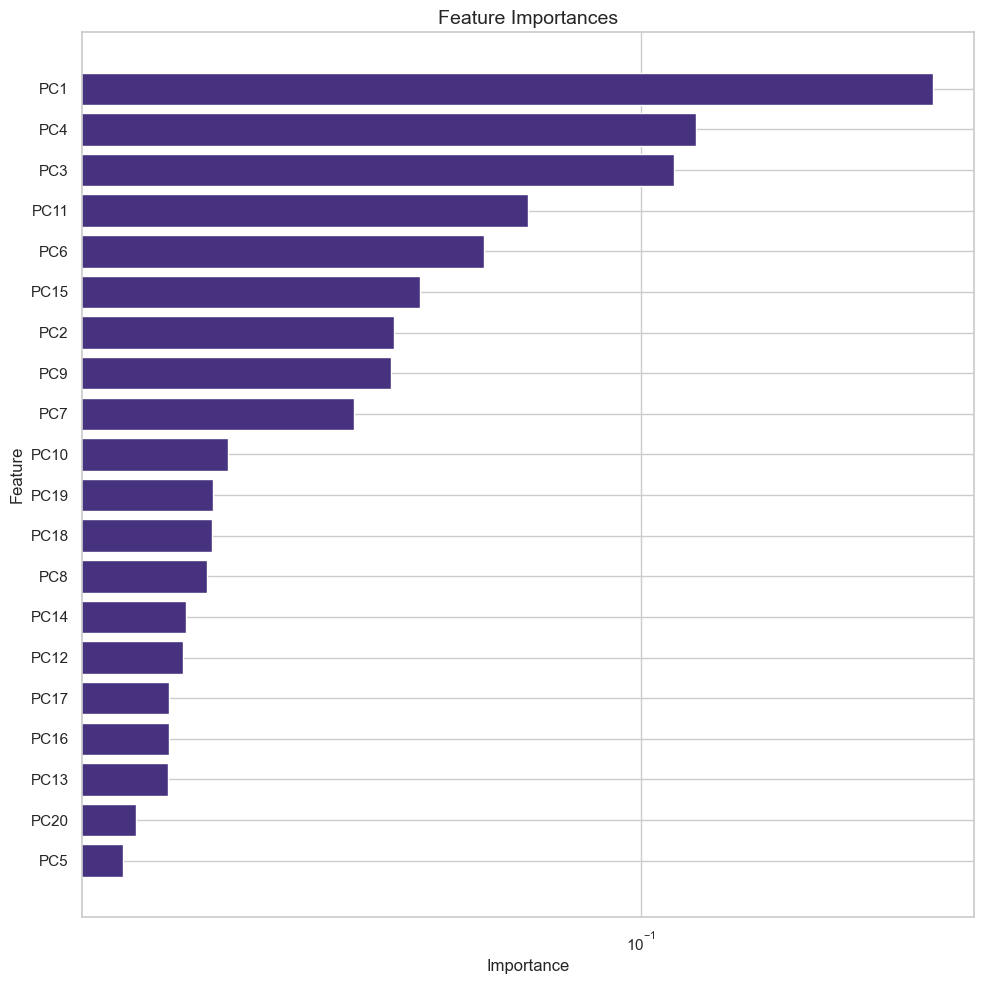

In [19]:
# finding most important features in the model
feature_importances = pd.DataFrame(rf_model.feature_importances_,
                                   index = X_train.columns,
                                   columns=['importance']).sort_values('importance', ascending=False)

fig, ax = plt.subplots(figsize=(10, 10))
sns.set(style='whitegrid')
sns.set_palette("viridis")

# sorting feature importances
feature_importances = feature_importances.sort_values('importance', ascending=True)

# bar chart of feature importances
ax.barh(feature_importances.index, feature_importances['importance'])

# making y axis logaritmic
ax.set_xscale('log')

ax.set_ylabel('Feature')
ax.set_xlabel('Importance')
ax.set_title('Feature Importances', fontsize=14)
ax.set_yticklabels(feature_importances.index)

fig.tight_layout()

In [13]:
# identifying the three most important features
top_3_features = feature_importances.sort_values('importance', ascending=False).head(3)
first = top_3_features.index[0]
second = top_3_features.index[1]
third = top_3_features.index[2]

print(f"The three most important features are: \033[1m{first}\033[0;0m, \033[1m{second}\033[0;0m, and \033[1m{third}\033[0;0m.")

The three most important features are: PC1, PC4, and PC3.


In [16]:
# retrieving loadings from model setup
loadings = pd.read_csv(data_path/f'pca_loadings_{compound}_{site}.csv', index_col=0)
loadings

# extracting loadings of top 3 most important PCAs
# based on names of the identified most important PCs
first_pca = loadings[first]
second_pca = loadings[second]
third_pca = loadings[third]

# identifying features with the highest loadings in top 3 PCAs
first_pca = first_pca.abs().sort_values(ascending=False)
second_pca = second_pca.abs().sort_values(ascending=False)
third_pca = third_pca.abs().sort_values(ascending=False)

print(f"Top 5 features in {first}: {first_pca.head(3).index.values}")
print(f"Top 5 features in {second}: {second_pca.head(3).index.values}")
print(f"Top 5 features in {third}: {third_pca.head(3).index.values}")

Top 5 features in PC1: ['u500_4' 'u500_3' 'u500_3_past']
Top 5 features in PC4: ['u500_2' 'u500_2_past' 'u500_1_past']
Top 5 features in PC3: ['v10_7' 'v10_15_past' 'v10_7_past']


In [17]:
# identifying what position importance blh is in for PCA2, 12 and 11
print(f"Position of 'blh' in {first}: {first_pca.index.get_loc('blh')}")
print(f"Position of 'blh' in {second}: {second_pca.index.get_loc('blh')}")
print(f"Position of 'blh' in {third}: {third_pca.index.get_loc('blh')}")

Position of 'blh' in PC1: 38
Position of 'blh' in PC4: 127
Position of 'blh' in PC3: 71


Text(0.5, 1.02, 'Feature Importances for PCA Loadings')

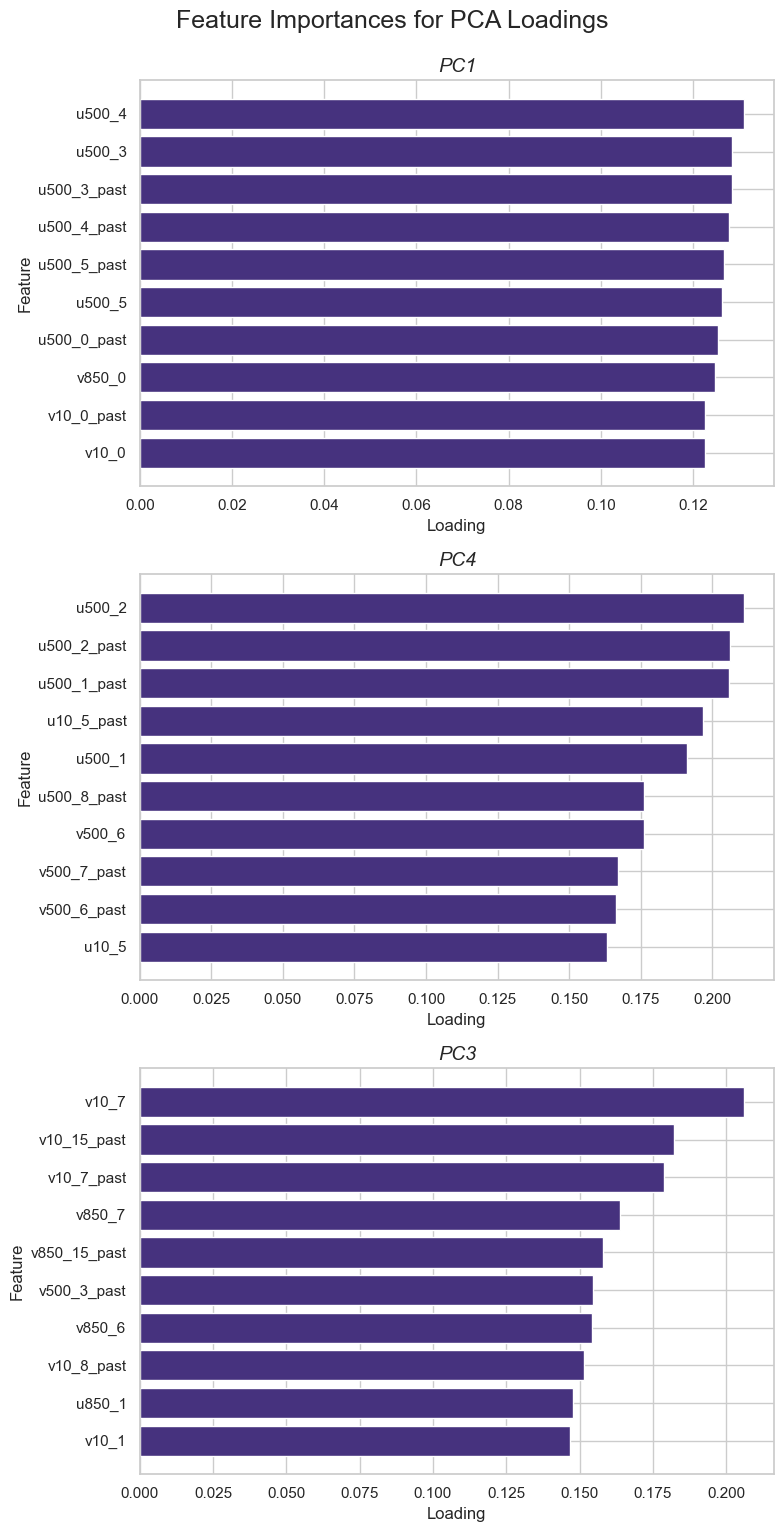

In [18]:
# plotting feature importances for loading of PCA2, 12 and 11
fig, axes = plt.subplots(3,1,figsize=(8, 15))
sns.set(style='whitegrid')
sns.set_palette("viridis")

# filtering feature importances for PCA2 - only including 10 most important features and sorting them
first_pca = first_pca.loc[first_pca.index[:10]].sort_values(ascending=True)
second_pca = second_pca.loc[second_pca.index[:10]].sort_values(ascending=True)
third_pca = third_pca.loc[third_pca.index[:10]].sort_values(ascending=True)

# bar chart of feature importances
axes[0].barh(first_pca.index, first_pca)
axes[1].barh(second_pca.index, second_pca)
axes[2].barh(third_pca.index, third_pca)

# adding titles and labels
axes[0].set_ylabel('Feature')
axes[0].set_xlabel('Loading')
axes[0].set_title(f'{first}', fontsize=14, fontstyle='italic')

axes[1].set_ylabel('Feature')
axes[1].set_xlabel('Loading')
axes[1].set_title(f'{second}', fontsize=14, fontstyle='italic')

axes[2].set_ylabel('Feature')
axes[2].set_xlabel('Loading')
axes[2].set_title(f'{third}', fontsize=14, fontstyle='italic')

fig.tight_layout()
fig.suptitle('Feature Importances for PCA Loadings', fontsize=18, y=1.02)